In [5]:
import os
import cv2
import operator
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib
from IPython.display import Image, display
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import random
from glob import glob
import pylab as pl
# import imutils
from tqdm import tqdm
import pickle
import random

# ========================== Tensorflow & Keras Library =======================
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, Average, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.resnet import ResNet50, ResNet152
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet169, DenseNet121 # DenseNet121 --> 0.98 accuracy
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB7, EfficientNetB6
from tensorflow.keras.applications import NASNetLarge, MobileNetV2
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.utils import plot_model


# ======================= Scikit-Learn Library ========================
import sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report)
import xgboost
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore")

In [6]:
# Check all the version of the python library

print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Matplotlib version: ", matplotlib.__version__)
print("Seaborn version: ", sns.__version__)
print("Tensorflow version: ", tf.__version__)
print("Scikit-learn version: ", sklearn.__version__)
print("Cv2 version: ", cv2.__version__)
print("Xgboost version: ", xgboost.__version__)

Numpy version:  1.26.1
Pandas version:  1.4.4
Matplotlib version:  3.5.3
Seaborn version:  0.13.0
Tensorflow version:  2.14.0
Scikit-learn version:  1.1.3
Cv2 version:  4.5.5
Xgboost version:  2.0.0


In [7]:
# GPU Information

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Sun Oct 15 15:18:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8     5W /  N/A |    134MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
print('Number of GPUs: ', len(tf.config.list_physical_devices('GPU')))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs:  0


IndexError: list index out of range

In [9]:
def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


seed = 111
set_seed(seed)

In [10]:
def category_counter(path):
    data_information = {}
    img_count = []
    tumor_category = os.listdir(path=path)

    for i in range(len(tumor_category)):
        number_of_img = len(os.listdir(path=f"{path}/{tumor_category[i]}/"))
        # print(f"Category Name: '{tumor_category[i]}' => Number of image: {number_of_img}")
        img_count.append(number_of_img)

    # Add the tumor class to the dictonary
    data_information["tumor_classes"] = tumor_category
    data_information["image_count"] = img_count

    return data_information

In [19]:
data_path = "D:/Final year project/Dataset2/CleandMRIImageData80_20"

{'tumor_classes': ['glioma', 'meningioma', 'notumor', 'pituitary_adenoma'], 'image_count': [415, 416, 416, 415]}


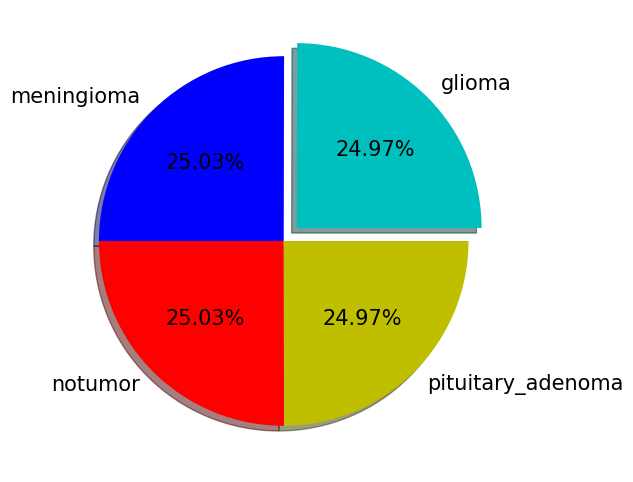

In [21]:
# Call the function and pass path

# For test dataset
test_data_info = category_counter(path=os.path.join(data_path, "D:/Final year project/Dataset2/CleandMRIImageData80_20", "Testing"))
print(test_data_info)

# Visualize it in pie chart for test dataset

plt.figure(figsize=(6,6))
explode = [0.1, 0, 0, 0] # To slice the perticuler section
colors = ["c", 'b','r','y'] # Color of each section
textprops = {"fontsize":15} # Font size of text in pie chart

plt.pie(x=test_data_info["image_count"],
        labels=test_data_info["tumor_classes"],
        explode=explode,
        colors=colors,
        textprops=textprops,
        autopct="%.2f%%",
        shadow=True)

plt.show()


{'tumor_classes': ['glioma', 'meningioma', 'notumor', 'pituitary_adenoma'], 'image_count': [1665, 1643, 1655, 1685]}


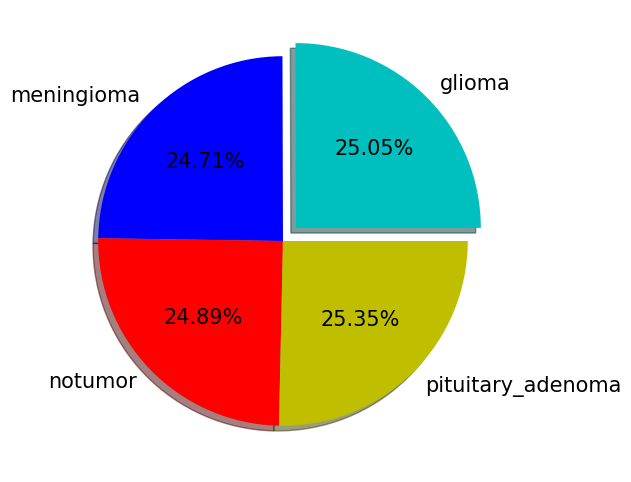

In [22]:
# Call the function and pass path

# For training dataset

training_data_info = category_counter(path=os.path.join(data_path, "D:/Final year project/Dataset2/CleandMRIImageData80_20", "Training"))
print(training_data_info)


# Visualize it in pie chart for test dataset

plt.figure(figsize=(6,6))
explode = [0.1, 0, 0, 0] # To slice the perticuler section
colors = ["c", 'b','r','y'] # Color of each section
textprops = {"fontsize":15} # Font size of text in pie chart

plt.pie(x=training_data_info["image_count"],
        labels=training_data_info["tumor_classes"],
        explode=explode,
        colors=colors,
        textprops=textprops,
        autopct="%.2f%%",
        shadow=True)

plt.show()

In [23]:
# Check Class wise number of images

for_test_data = test_data_info['image_count']
for_train_data = training_data_info['image_count']

total_img_by_class = [for_test_data[i] + for_train_data[i] for i in range(len(for_train_data))]

print("All the classes: ", training_data_info["tumor_classes"])
print("Total Number of image based on their classes: ", total_img_by_class)
print("Total Number of Images for traing dataset: ", sum(for_train_data))
print("Total Number of Images for test dataset: ", sum(for_test_data))
print("Total Number of images: ", sum(total_img_by_class))

All the classes:  ['glioma', 'meningioma', 'notumor', 'pituitary_adenoma']
Total Number of image based on their classes:  [2080, 2059, 2071, 2100]
Total Number of Images for traing dataset:  6648
Total Number of Images for test dataset:  1662
Total Number of images:  8310


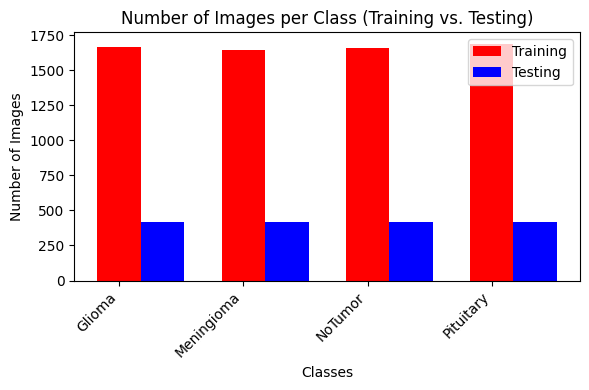

In [25]:
def plot_class_counts(train_counts, test_counts):
    classes = list(train_counts.keys())
    train_counts = list(train_counts.values())
    test_counts = list(test_counts.values())

    width = 0.35
    x = np.arange(len(classes))

    plt.figure(figsize=(6, 4))
    plt.bar(x=x, height=train_counts, width=width, label='Training', color='red')
    plt.bar(x=x + 0.35, height=test_counts, width=width, label='Testing', color='blue')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class (Training vs. Testing)')
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


training_path = os.path.join(data_path, "D:/Final year project/Dataset2/CleandMRIImageData80_20", "Training")
testing_path = os.path.join(data_path, "D:/Final year project/Dataset2/CleandMRIImageData80_20", "Testing")

train_class_counts = {
    'Glioma': len(os.listdir(os.path.join(training_path, "glioma"))),
    'Meningioma': len(os.listdir(os.path.join(training_path, "meningioma"))),
    'NoTumor': len(os.listdir(os.path.join(training_path, "notumor"))),
    'Pituitary': len(os.listdir(os.path.join(training_path, "pituitary_adenoma")))
}

test_class_counts = {
    'Glioma': len(os.listdir(os.path.join(testing_path, "glioma"))),
    'Meningioma': len(os.listdir(os.path.join(testing_path, "meningioma"))),
    'NoTumor': len(os.listdir(os.path.join(testing_path, "notumor"))),
    'Pituitary': len(os.listdir(os.path.join(testing_path, "pituitary_adenoma")))
}

plot_class_counts(train_class_counts, test_class_counts)

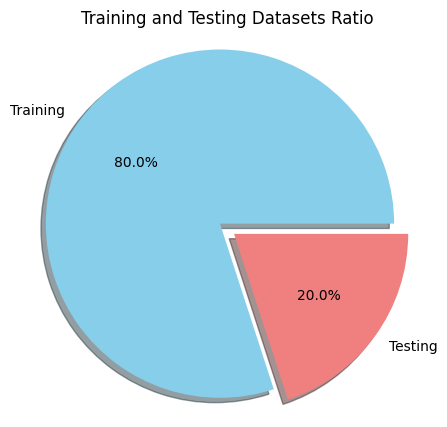

In [26]:
total_training_data = sum(for_train_data)
total_test_data = sum(for_test_data)

sizes = [total_training_data, total_test_data]
labels = ['Training', 'Testing']
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)

plt.figure(figsize=(5, 5))
plt.pie(x=sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', shadow=True)
plt.title("Training and Testing Datasets Ratio")
plt.axis('equal')
# plt.savefig('pie-00.png')
# plt.close()
plt.show()

In [27]:
training_data_path = os.path.join(data_path, "D:/Final year project/Dataset2/CleandMRIImageData80_20", "Training")
testing_data_path = os.path.join(data_path, "D:/Final year project/Dataset2/CleandMRIImageData80_20", "Testing")

In [28]:
# ========================== Version 1 ==============================

# Image augmentation for training images
generator_for_train = ImageDataGenerator(rescale=1. / 255,
                                     rotation_range=7,
                                     horizontal_flip=True,
                                     shear_range=0.1,
                                     height_shift_range=0.07,
                                     zoom_range=0.1)

# Image augmentation for test images
generator_for_test = ImageDataGenerator(rescale=1. / 255,
                                     rotation_range=7,
                                     horizontal_flip=True,
                                     shear_range=0.1,
                                     height_shift_range=0.07,
                                     zoom_range=0.1)



train = generator_for_train.flow_from_directory(directory=training_data_path,
                                            target_size=(224,224), # height and width of images to feed into CNN
                                            batch_size=32,
                                            class_mode= "categorical",
                                            color_mode='rgb',
                                            seed=seed)




test = generator_for_test.flow_from_directory(directory=testing_data_path,
                                          target_size=(224,224), # height and width of images to feed into CNN
                                          batch_size=32,
                                          class_mode= "categorical",
                                          color_mode='rgb',
                                          seed=seed)

Found 6648 images belonging to 4 classes.
Found 1662 images belonging to 4 classes.


In [29]:
# ========================== Version 2 ==============================

set_seed(seed)

# Image augmentation for training images
generator_for_train = ImageDataGenerator(rescale=1. / 255,
                                         rotation_range=10,
                                         brightness_range=(0.85, 1.15),
                                         width_shift_range=0.02,
                                         height_shift_range=0.02,
                                         shear_range=12.5,
                                         zoom_range=0.1,
                                         horizontal_flip=True,
                                         vertical_flip=False,
                                         fill_mode="nearest")

# Image augmentation for test images
# generator_for_test = ImageDataGenerator(rescale=1. / 255)
# Image augmentation for test images
generator_for_test = ImageDataGenerator(rescale=1. / 255,
                                        rotation_range=10,
                                        brightness_range=(0.85, 1.15),
                                        width_shift_range=0.02,
                                        height_shift_range=0.02,
                                        shear_range=12.5,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode="nearest")



train = generator_for_train.flow_from_directory(directory=training_data_path,
                                                target_size=(224,224), # height and width of images to feed into CNN
                                                batch_size=32,
                                                class_mode= "categorical",
                                                color_mode='rgb',
                                                seed=seed)




test = generator_for_test.flow_from_directory(directory=testing_data_path,
                                              target_size=(224,224), # height and width of images to feed into CNN
                                              batch_size=32,
                                              class_mode= "categorical",
                                              color_mode='rgb',
                                              shuffle=False,
                                              seed=seed)

Found 6648 images belonging to 4 classes.
Found 1662 images belonging to 4 classes.


In [30]:
train.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary_adenoma': 3}

In [31]:
train.class_indices.keys()

dict_keys(['glioma', 'meningioma', 'notumor', 'pituitary_adenoma'])

In [32]:
class_indices_train_list = list(train.class_indices.keys())
class_indices_train_list

['glioma', 'meningioma', 'notumor', 'pituitary_adenoma']

In [33]:
train.classes

array([0, 0, 0, ..., 3, 3, 3])

In [34]:
train.samples

6648

In [35]:
test.samples

1662

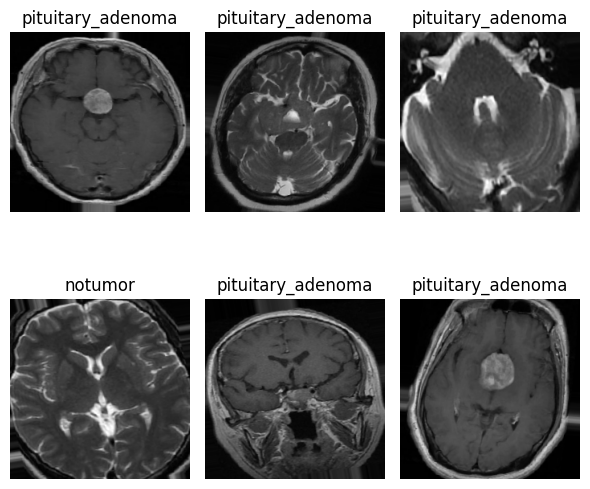

In [36]:
# Retrieve a batch of images and labels from the train generator
images, labels = next(train)

# Select 6 random samples from the batch
num_samples_to_display = 6

random_indices = np.random.choice(len(images), num_samples_to_display, replace=False)
random_images = images[random_indices]
random_labels = labels[random_indices]

# print(random_indices)
# print(random_images)
# print(random_labels)

# Display the images along with their corresponding labels
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(random_images[i])
    label_index = np.argmax(random_labels[i])  # Get the index of the label (assuming one-hot encoding)
    class_name = train.class_indices
    class_name = dict((v, k) for k, v in class_name.items())
    ax.set_title(class_name[label_index])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [45]:
# Create a directory to store the final model after trained
parent_dir =  os.getcwd()

# Specify the desired folder name
folder_name = 'BestModels'

# Concatenate parent directory and folder name
folder_path = os.path.join(parent_dir, folder_name)

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Directory '{folder_name}' created successfully at {folder_path}")
else:
    print(f"Folder '{folder_name}' already exists at {folder_path}")

Folder 'BestModels' already exists at C:\Users\shaad shaikh\BestModels


In [46]:
# Save the model training history

parent_dir2 =  os.getcwd()

# Specify the desired folder name
model_history_dir = 'ModelHistory'

# Concatenate parent directory and folder name
history_store_path = os.path.join(parent_dir2, model_history_dir)


# Check if the directory already exists.
if not os.path.exists(history_store_path):
    # Create the directory if it doesn't exist.
    os.makedirs(history_store_path)
    print(f"Directory '{history_store_path}' created successfully.")
else:
    print(f"Directory '{history_store_path}' already exists.")

Directory 'C:\Users\shaad shaikh\ModelHistory' created successfully.


In [47]:
# Save the model training AllFigure

parent_dir3 =  os.getcwd()

# Specify the desired folder name
model_figure_dir = 'AllFigure'

# Concatenate parent directory and folder name
figure_store_path = os.path.join(parent_dir3, model_figure_dir)


# Check if the directory already exists.
if not os.path.exists(figure_store_path):
    # Create the directory if it doesn't exist.
    os.makedirs(figure_store_path)
    print(f"Directory '{figure_store_path}' created successfully.")
else:
    print(f"Directory '{figure_store_path}' already exists.")

Directory 'C:\Users\shaad shaikh\AllFigure' created successfully.


In [48]:
def save_model_history(history, filename):
    with open(file=os.path.join(history_store_path, filename), mode="wb") as file:
        pickle.dump(obj=history.history, file=file)

In [49]:
def plot_graph(history, title):
    font_size = 9
    plt.figure(figsize=(10, 10))
    # Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], label='Train Accuracy')
    plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy of {title}', fontsize=font_size)
    plt.legend()
    plt.savefig(os.path.join(figure_store_path, f'{title}_acc&val_acc.png'))  # Save as PNG image

    # Loss
    plt.subplot(3, 2, 2)
    plt.plot(range(1, len(history['loss']) + 1), history['loss'], label='Train Loss')
    plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss of {title}', fontsize=font_size)
    plt.legend()
    plt.savefig(os.path.join(figure_store_path, f'{title}_loss&val_loss.png'))  # Save as PNG image

    # Precision
    plt.subplot(3, 2, 3)
    plt.plot(range(1, len(history['precision']) + 1), history['precision'], label='Train Precision')
    plt.plot(range(1, len(history['val_precision']) + 1), history['val_precision'], label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title(f'Training and Validation Precision of {title}', fontsize=font_size)
    plt.legend()
    plt.savefig(os.path.join(figure_store_path, f'{title}_pre&val_pre.png'))  # Save as PNG image

    # Recall
    plt.subplot(3, 2, 4)
    plt.plot(range(1, len(history['recall']) + 1), history['recall'], label='Train Recall')
    plt.plot(range(1, len(history['val_recall']) + 1), history['val_recall'], label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title(f'Training and Validation Recall of {title}', fontsize=font_size)
    plt.legend()
    plt.savefig(os.path.join(figure_store_path, f'{title}_recall&val_recall.png'))  # Save as PNG image

    # AUC
    plt.subplot(3, 2, 5)
    plt.plot(range(1, len(history['auc']) + 1), history['auc'], label='Train AUC')
    plt.plot(range(1, len(history['val_auc']) + 1), history['val_auc'], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title(f'Training and Validation AUC of {title}', fontsize=font_size)
    plt.legend()
    plt.savefig(os.path.join(figure_store_path, f'{title}_auc&val_auc.png'))  # Save as PNG image

    # categorical_accuracy
    plt.subplot(3, 2, 6)
    plt.plot(range(1, len(history['categorical_accuracy']) + 1), history['categorical_accuracy'], label='Train CA')
    plt.plot(range(1, len(history['val_categorical_accuracy']) + 1), history['val_categorical_accuracy'], label='Validation CA')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title(f'Training and Validation Categorical Accuracy of {title}', fontsize=font_size)
    plt.legend()
    plt.savefig(os.path.join(figure_store_path, f'{title}_cat&cat_acc.png'))  # Save as PNG image

    plt.tight_layout()
    plt.show()

In [50]:
def create_confusion_matrix(model, test_generator):
    model_pred = model.predict(test_generator)
    y_pred = np.argmax(model_pred, axis=1)
    y_true = test_generator.classes

    # Create a confusion matrix
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

    return cm, y_true, y_pred

def show_confusion_matrix(model, test_generator, labels):
    # Call the function to create a confusion matrix
    cm, y_true, y_pred = create_confusion_matrix(model=model, test_generator=test_generator)

    # Plot the confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    # plt.xticks(ticks=np.arange(len(labels)) , labels=labels)
    # plt.yticks(ticks=np.arange(len(labels)), labels=labels)

    plt.xticks(ticks=np.arange(len(labels)) + 0.5,
           labels=[name.title() for name in labels], ha='center')
    plt.yticks(ticks=np.arange(len(labels)) + 0.5,
           labels=[name.title() for name in labels], va='center')

    plt.show()

    return cm, y_true, y_pred

In [51]:
def show_precision_recall_f1Score(cm, class_labels):
    # Calculate precision, recall, and F1-score from the confusion matrix
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Print precision, recall, and F1-score for each class
    for i, category in enumerate(class_labels):
        print(f"Class: {category}")
        print(f"Precision: {round(precision[i] * 100, 2)}")
        print(f"Recall: {round(recall[i] * 100, 2)}")
        print(f"F1-Score: {round(f1_score[i] * 100, 2)}")
        print("=" * 40)

In [52]:
# Delete file function

def delete_all_files_in_folder(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Loop through the list and delete each file
    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Deleted {file_path}")
            else:
                print(f"{file_path} is not a file. Skipped.")
        except Exception as e:
            print(f"Error while deleting {file_path}: {e}")

In [53]:
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
NUMBER_OF_EPOCH = 50

In [54]:
# =================================== Version-1 ===================================
# =================================================================================

# here image shape is = (224, 224, 3)
vgg16_conv = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the trained layers
for layer in vgg16_conv.layers:
    layer.trainable = False

vgg_feedforward = Flatten()(vgg16_conv.output)
# vgg_feedforward = Dense(units=4096,activation ='relu')(vgg_feedforward)
# vgg_feedforward = Dense(units=1024,activation ='relu')(vgg_feedforward)
vgg_feedforward = Dense(units=512,activation ='relu')(vgg_feedforward)
vgg_feedforward = Dense(units=256,activation ='relu')(vgg_feedforward)
# Here, units=4 means our target class is 4
prediction = Dense(units=4, activation='softmax')(vgg_feedforward)

model_vgg16 = Model(inputs=vgg16_conv.input, outputs=prediction)


# learning_rate=0.001, beta_1=0.9, beta_2=0.999 # default value

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

optimizer = tf.keras.optimizers.Adam()
metrics = ['accuracy','Precision','Recall', 'AUC', 'categorical_accuracy']
model_vgg16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

model1_es = EarlyStopping(monitor='loss', min_delta=1e-11, patience=12, verbose=1)
model1_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = os.path.join(os.getcwd(), "BestModels", "vgg16_model.h5"),
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             verbose = 1)

# Save the training information or log
vgg16_training_history_log = CSVLogger(filename=os.path.join(history_store_path, "vgg16.csv"), separator=',', append=True)

model_vgg16.summary()

58889256/58889256 [==============================] - 11s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [55]:
# =================================== Version-2 ===================================
# =================================================================================


# here image shape is = (224, 224, 3)
vgg16_conv = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the trained layers
for layer in vgg16_conv.layers:
    layer.trainable = False

# Create the feedforward layers
vgg_feedforward = Flatten()(vgg16_conv.output)
# vgg_feedforward = Dense(units=512, activation='relu', kernel_regularizer=L2(l2=0.001))(vgg_feedforward)
# vgg_feedforward = BatchNormalization()(vgg_feedforward)
# vgg_feedforward = Dropout(0.5)(vgg_feedforward)
vgg_feedforward = Dense(units=256, activation='relu', kernel_regularizer=L2(l2=0.001))(vgg_feedforward)
# vgg_feedforward = BatchNormalization()(vgg_feedforward)
vgg_feedforward = Dense(units=128, activation='relu', kernel_regularizer=L2(l2=0.001))(vgg_feedforward)
vgg_feedforward = Dropout(0.3)(vgg_feedforward)

# Output layer
prediction = Dense(units=4, activation='softmax')(vgg_feedforward)

# Create the modified model
model_vgg16 = Model(inputs=vgg16_conv.input, outputs=prediction)


# learning_rate=0.001, beta_1=0.9, beta_2=0.999 # default value

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

metrics = ['accuracy','Precision','Recall', 'AUC', 'categorical_accuracy']

model_vgg16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

model1_es = EarlyStopping(monitor='loss', min_delta=1e-11, patience=12, verbose=1)

model1_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = os.path.join(os.getcwd(), "BestModels", "vgg16_model.h5"),
                             monitor = 'categorical_accuracy',
                             save_best_only = True,
                             verbose = 1)

# Save the training information or log
vgg16_training_history_log = CSVLogger(filename=os.path.join(history_store_path, "vgg16.csv"), separator=',', append=True)

model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [56]:
vgg16_fit_history = model_vgg16.fit(x=train,
                            validation_data=test,
                            epochs=NUMBER_OF_EPOCH,
                            steps_per_epoch=train.samples // BATCH_SIZE,
                            validation_steps=test.samples // BATCH_SIZE,
                            callbacks=[model1_es, model1_rlr, model1_mcp, vgg16_training_history_log])

Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 1.2753 - accuracy: 0.6625 - precision: 0.7214 - recall: 0.5834 - auc: 0.8657 - categorical_accuracy: 0.6625
Epoch 1: categorical_accuracy improved from -inf to 0.66248, saving model to C:\Users\shaad shaikh\BestModels\vgg16_model.h5
207/207 [==============================] - 677s 3s/step - loss: 1.2753 - accuracy: 0.6625 - precision: 0.7214 - recall: 0.5834 - auc: 0.8657 - categorical_accuracy: 0.6625 - val_loss: 1.0254 - val_accuracy: 0.6783 - val_precision: 0.7576 - val_recall: 0.5956 - val_auc: 0.8923 - val_categorical_accuracy: 0.6783 - lr: 0.0010
Epoch 2/50
207/207 [==============================] - ETA: 0s - loss: 0.7637 - accuracy: 0.7828 - precision: 0.8256 - recall: 0.7282 - auc: 0.9451 - categorical_accuracy: 0.7828
Epoch 2: categorical_accuracy improved from 0.66248 to 0.78280, saving model to C:\Users\shaad shaikh\BestModels\vgg16_model.h5
207/207 [==============================] - 590s 3s/step - loss: 0.

207/207 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.9451 - precision: 0.9521 - recall: 0.9365 - auc: 0.9958 - categorical_accuracy: 0.9451
Epoch 27: categorical_accuracy did not improve from 0.94755
207/207 [==============================] - 559s 3s/step - loss: 0.2527 - accuracy: 0.9451 - precision: 0.9521 - recall: 0.9365 - auc: 0.9958 - categorical_accuracy: 0.9451 - val_loss: 0.3997 - val_accuracy: 0.8928 - val_precision: 0.9043 - val_recall: 0.8854 - val_auc: 0.9831 - val_categorical_accuracy: 0.8928 - lr: 2.0000e-04
Epoch 28/50
207/207 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9518 - precision: 0.9594 - recall: 0.9463 - auc: 0.9964 - categorical_accuracy: 0.9518
Epoch 28: categorical_accuracy improved from 0.94755 to 0.95178, saving model to C:\Users\shaad shaikh\BestModels\vgg16_model.h5
207/207 [==============================] - 564s 3s/step - loss: 0.2374 - accuracy: 0.9518 - precision: 0.9594 - recall: 0.9463 - auc: 0.

Epoch 41/50
207/207 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9701 - precision: 0.9733 - recall: 0.9658 - auc: 0.9983 - categorical_accuracy: 0.9701
Epoch 41: categorical_accuracy improved from 0.96493 to 0.97007, saving model to C:\Users\shaad shaikh\BestModels\vgg16_model.h5
207/207 [==============================] - 580s 3s/step - loss: 0.1769 - accuracy: 0.9701 - precision: 0.9733 - recall: 0.9658 - auc: 0.9983 - categorical_accuracy: 0.9701 - val_loss: 0.3448 - val_accuracy: 0.9136 - val_precision: 0.9216 - val_recall: 0.9075 - val_auc: 0.9872 - val_categorical_accuracy: 0.9136 - lr: 4.0000e-05
Epoch 42/50
207/207 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9714 - precision: 0.9751 - recall: 0.9666 - auc: 0.9988 - categorical_accuracy: 0.9714
Epoch 42: categorical_accuracy improved from 0.97007 to 0.97143, saving model to C:\Users\shaad shaikh\BestModels\vgg16_model.h5
207/207 [==============================] - 580s 3s/step

In [57]:
save_model_history(history=vgg16_fit_history, filename="vgg16.pkl")

In [58]:
model_test_vgg16 = model_vgg16.evaluate(x=test, steps=test.samples // BATCH_SIZE)

51/51 [==============================] - 116s 2s/step - loss: 0.3169 - accuracy: 0.9222 - precision: 0.9271 - recall: 0.9197 - auc: 0.9888 - categorical_accuracy: 0.9222


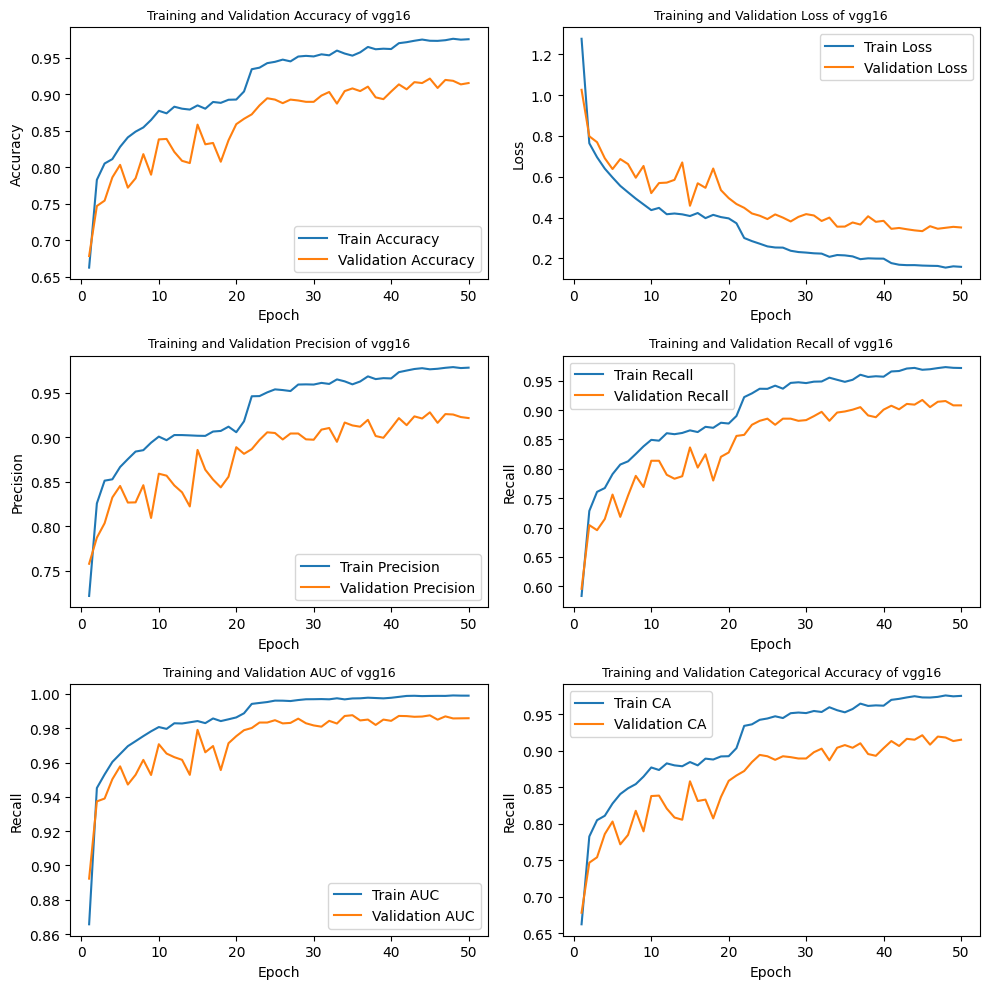

52/52 [==============================] - 116s 2s/step


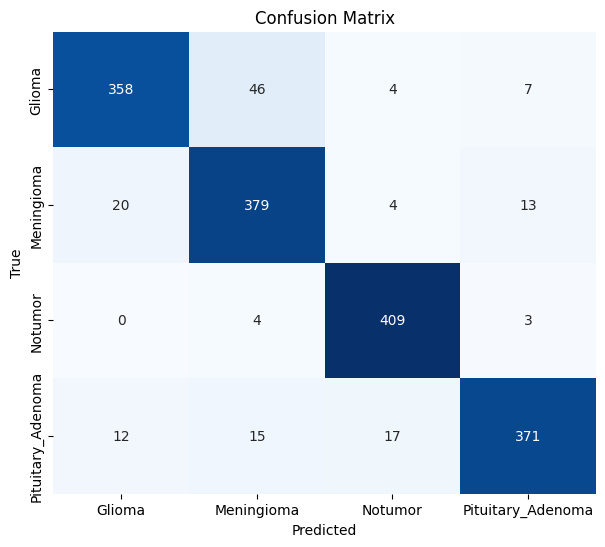

Class: glioma
Precision: 91.79
Recall: 86.27
F1-Score: 88.94
Class: meningioma
Precision: 85.36
Recall: 91.11
F1-Score: 88.14
Class: notumor
Precision: 94.24
Recall: 98.32
F1-Score: 96.24
Class: pituitary_adenoma
Precision: 94.16
Recall: 89.4
F1-Score: 91.72
                   precision    recall  f1-score   support

           glioma       0.92      0.86      0.89       415
       meningioma       0.85      0.91      0.88       416
          notumor       0.94      0.98      0.96       416
pituitary_adenoma       0.94      0.89      0.92       415

         accuracy                           0.91      1662
        macro avg       0.91      0.91      0.91      1662
     weighted avg       0.91      0.91      0.91      1662

Accuracy:  97.61
=================== For Macro Average ===================
Precision score:  91.39
Recall score:  91.27
F1 score:  91.26


In [60]:
# Load vgg16 model

load_vgg16 = load_model(filepath=os.path.join(os.getcwd(), "BestModels", "vgg16_model.h5"))

# Load DenseNet-121 model history

with open(file=os.path.join(history_store_path, "vgg16.pkl"), mode="rb") as file:
    vgg16_history = pickle.load(file=file)

plot_graph(history=vgg16_history, title="vgg16")

# Show confusion matrix
cm, y_true, y_pred = show_confusion_matrix(model=load_vgg16, test_generator=test, labels=class_indices_train_list)

# Show precision, recall, f1-score matrix
show_precision_recall_f1Score(cm=cm, class_labels=class_indices_train_list)

print(classification_report(y_true=y_true, y_pred=y_pred, target_names=class_indices_train_list))


print("Accuracy: ", round(max(vgg16_history['accuracy']) * 100, 2))
# print("Validation Accuracy: ", round(max(vgg16_history['val_accuracy']) * 100, 2))
print("=================== For Macro Average ===================")
print("Precision score: ", round(precision_score(y_true=y_true, y_pred=y_pred, average="macro") * 100 , 2))
print("Recall score: ", round(recall_score(y_true=y_true, y_pred=y_pred, average="macro") * 100, 2))
print("F1 score: ", round(f1_score(y_true=y_true, y_pred=y_pred, average="macro") * 100, 2))